In [2]:
# ==========================================================
# 10_RF_embeddings_only — Setup + Load + Merge (embeddings-only)
# ==========================================================

# --- Project root for imports/paths ---
import sys
from pathlib import Path

if "__file__" in globals():
    ROOT = Path(__file__).resolve().parents[1]
else:
    ROOT = Path.cwd().parents[0]  # notebook vive em /notebooks

if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

print(f"📁 ROOT: {ROOT.resolve()}")

# --- Imports ---
import pandas as pd
import numpy as np
from src.utils import ConfigLoader

# --- Config & paths ---
cfg = ConfigLoader.load("base.yaml")

data_proc = (ROOT / cfg["paths"]["data_processed"]).resolve()
splits_dir = data_proc / "splits"
emb_dir    = data_proc / "embeddings"

print("data_processed:", data_proc)
print("splits_dir    :", splits_dir)
print("embeddings    :", emb_dir)

# --- Splits rotulados (para obter 'class') ---
df_train = pd.read_csv(splits_dir / "train_nodes.csv")
df_test1 = pd.read_csv(splits_dir / "test1_nodes.csv")
df_test2 = pd.read_csv(splits_dir / "test2_nodes.csv")
print("✅ splits shapes:", "train", df_train.shape, "test1", df_test1.shape, "test2", df_test2.shape)

# --- Embeddings skipGCN (somente emb_*) ---
sk_train = pd.read_csv(emb_dir / "train_embeddings_skipgcn.csv")  # txId, time_step, emb_*
sk_test1 = pd.read_csv(emb_dir / "test1_embeddings_skipgcn.csv")
sk_test2 = pd.read_csv(emb_dir / "test2_embeddings_skipgcn.csv")

# --- Embeddings GCPAL (contêm feature_* + emb_gcpal_* e podem conter 'class') ---
gc_train = pd.read_csv(emb_dir / "train_embeddings_gcpal.csv")
gc_test1 = pd.read_csv(emb_dir / "test1_embeddings_gcpal.csv")
gc_test2 = pd.read_csv(emb_dir / "test2_embeddings_gcpal.csv")

print("✅ embeddings (raw) shapes:",
      "\n  skipGCN:", sk_train.shape, sk_test1.shape, sk_test2.shape,
      "\n  GCPAL  :", gc_train.shape, gc_test1.shape, gc_test2.shape)

# ---------------------------
# Helpers para merge + normalizar 'class'
# ---------------------------
def _merge_with_class(split_df, emb_df):
    """
    Faz merge pela chave 'txId' e garante coluna única 'class'.
    Se o emb_df já tiver 'class', usamos sufixos e normalizamos:
       class = class_split (se existir) senão class_emb
    """
    has_class_in_emb = "class" in emb_df.columns
    if has_class_in_emb:
        merged = split_df[["txId", "class"]].merge(
            emb_df, on="txId", how="inner", suffixes=("_split", "_emb")
        )
        # Resolve coluna 'class'
        if "class_split" in merged.columns:
            merged["class"] = merged["class_split"]
        elif "class_emb" in merged.columns:
            merged["class"] = merged["class_emb"]
        # Drop colunas duplicadas de class se existirem
        drop_cols = [c for c in ["class_split", "class_emb"] if c in merged.columns]
        merged = merged.drop(columns=drop_cols)
    else:
        merged = split_df[["txId", "class"]].merge(emb_df, on="txId", how="inner")
    return merged

# --- Merge + normalização de 'class' ---
df_train_sk = _merge_with_class(df_train, sk_train)
df_test1_sk = _merge_with_class(df_test1, sk_test1)
df_test2_sk = _merge_with_class(df_test2, sk_test2)

df_train_gc = _merge_with_class(df_train, gc_train)
df_test1_gc = _merge_with_class(df_test1, gc_test1)
df_test2_gc = _merge_with_class(df_test2, gc_test2)

# --- Seleção das colunas de embeddings (somente embeddings) ---
sk_cols = [c for c in df_train_sk.columns if c.startswith("emb_")]              # skipGCN: emb_*
gc_cols = [c for c in df_train_gc.columns if c.startswith("emb_gcpal_")]        # GCPAL: emb_gcpal_*

print(f"🔹 skipGCN emb cols: {len(sk_cols)}")
print(f"🔹 GCPAL   emb cols: {len(gc_cols)}")

# --- Shapes finais (somente embeddings nas features) ---
print("✅ prepared (embeddings-only) datasets:")
print(" skipGCN ->",
      "train", df_train_sk[ ['txId','class'] + sk_cols ].shape,
      "test1", df_test1_sk[ ['txId','class'] + sk_cols ].shape,
      "test2", df_test2_sk[ ['txId','class'] + sk_cols ].shape)
print(" GCPAL   ->",
      "train", df_train_gc[ ['txId','class'] + gc_cols ].shape,
      "test1", df_test1_gc[ ['txId','class'] + gc_cols ].shape,
      "test2", df_test2_gc[ ['txId','class'] + gc_cols ].shape)


📁 ROOT: /Users/leonardoribeiro/Documents/DataScience/MBA_USP/TCC
data_processed: /Users/leonardoribeiro/Documents/DataScience/MBA_USP/TCC/data/processed
splits_dir    : /Users/leonardoribeiro/Documents/DataScience/MBA_USP/TCC/data/processed/splits
embeddings    : /Users/leonardoribeiro/Documents/DataScience/MBA_USP/TCC/data/processed/embeddings
✅ splits shapes: train (29894, 168) test1 (9983, 168) test2 (6687, 168)
✅ embeddings (raw) shapes: 
  skipGCN: (136265, 102) (37820, 102) (29684, 102) 
  GCPAL  : (29894, 296) (9983, 296) (6687, 296)
🔹 skipGCN emb cols: 100
🔹 GCPAL   emb cols: 128
✅ prepared (embeddings-only) datasets:
 skipGCN -> train (29894, 102) test1 (9983, 102) test2 (6687, 102)
 GCPAL   -> train (29894, 130) test1 (9983, 130) test2 (6687, 130)


# Treinando RF somente com embeddings

In [4]:
# ==========================================================
# RF (embeddings-only) com feature_sets no mesmo estilo (Local/1-hop/AF)
# Aqui: "skipGCN-only" e "GCPAL-only"
# ==========================================================
from src.models.baseline.runner import BaselineRunner
from src.results.store import ResultsStore

# 1) Define feature sets a partir dos nomes das colunas
feature_sets_sk = {
    "skipGCN-only": sk_cols,          # ex.: ['emb_0', 'emb_1', ...]
}
feature_sets_gc = {
    "GCPAL-only":   gc_cols,          # ex.: ['emb_gcpal_0', 'emb_gcpal_1', ...]
}

# 2) Seeds e runner
seed_global = cfg.get("general", {}).get("seed", 42)
seeds = [seed_global + i for i in range(5)]
runner = BaselineRunner(cfg, seeds)

# 3) Executa RF para cada conjunto (usando os DFs apropriados)
results_sk_only = runner.run_family(
    model_key="rf",
    feature_sets=feature_sets_sk,
    df_train=df_train_sk[["txId","class","time_step"] + sk_cols],
    df_test1=df_test1_sk[["txId","class","time_step"] + sk_cols],
    df_test2=df_test2_sk[["txId","class","time_step"] + sk_cols],
)

results_gc_only = runner.run_family(
    model_key="rf",
    feature_sets=feature_sets_gc,
    df_train=df_train_gc[["txId","class","time_step"] + gc_cols],
    df_test1=df_test1_gc[["txId","class","time_step"] + gc_cols],
    df_test2=df_test2_gc[["txId","class","time_step"] + gc_cols],
)

# 4) Persistência (namespaces separados)
artifacts = (ROOT / cfg["paths"].get("artifacts", "data/artifacts")).resolve()
artifacts.mkdir(parents=True, exist_ok=True)
store = ResultsStore(artifacts / "results.json")
rf_cfg = cfg["baselines"]["rf"]

for feat_name, runs in results_sk_only.items():  # feat_name == "skipGCN-only"
    for r in runs:
        store.append_run("rf_skipgcn_only", {
            "family": "rf",
            "feature_set": feat_name,
            "seed": r["seed"],
            "train_params": rf_cfg,
            "metrics": {
                "global": {
                    "35_42": r["Global (35–42)"],
                    "43_49": r["Global (43–49)"],
                    "35_49": r["Global (35–49)"],
                },
                "by_time_step": r["por_time_step"],
            },
        })

for feat_name, runs in results_gc_only.items():  # feat_name == "GCPAL-only"
    for r in runs:
        store.append_run("rf_gcpal_only", {
            "family": "rf",
            "feature_set": feat_name,
            "seed": r["seed"],
            "train_params": rf_cfg,
            "metrics": {
                "global": {
                    "35_42": r["Global (35–42)"],
                    "43_49": r["Global (43–49)"],
                    "35_49": r["Global (35–49)"],
                },
                "by_time_step": r["por_time_step"],
            },
        })

print("✅ RF (embeddings-only) concluído. Resultados salvos em:", (artifacts / "results.json").resolve())


✅ RF (embeddings-only) concluído. Resultados salvos em: /Users/leonardoribeiro/Documents/DataScience/MBA_USP/TCC/data/artifacts/results.json


In [5]:
# 6) (Opcional) Resumo curto em tela
import numpy as np
import pandas as pd
from IPython.display import display

# Unifica no formato esperado: { family_key: { feature_set: runs } }
results_summary = {
    "rf": {**results_sk_only, **results_gc_only}
}

def mean_std_str(values):
    arr = np.array(values, dtype=float)
    return f"{np.nanmean(arr):.3f} ± {np.nanstd(arr):.3f}"

summary_rows = []
for family_key, model_dict in results_summary.items():
    for feat_name, runs in model_dict.items():
        for label, key in [("Pré (35–42)", "Global (35–42)"),
                           ("Pós (43–49)", "Global (43–49)"),
                           ("Global (35–49)", "Global (35–49)")]:
            summary_rows.append({
                "Família": family_key.upper(),
                "Features": feat_name,
                "Período": label,
                "Gini":   mean_std_str([r[key]["Gini"] for r in runs]),
                "PR-AUC": mean_std_str([r[key]["PR-AUC"] for r in runs]),
                "PR-AUC/Prev": mean_std_str([r[key]["PR-AUC/Prev"] for r in runs]),
                "F1":     mean_std_str([r[key]["F1"] for r in runs]),
                "Recall": mean_std_str([r[key]["Recall"] for r in runs]),
                "Precision": mean_std_str([r[key]["Precision"] for r in runs]),
            })

df_summary_baseline = (
    pd.DataFrame(summary_rows)
      .set_index(["Família","Features","Período"])
      .sort_index()
)

display(df_summary_baseline)


Gini         PR-AUC  \
Família Features          Período                                        
RF      RF (GCPAL-only)   Global (35–49)  0.523 ± 0.014  0.219 ± 0.007   
                          Pré (35–42)     0.583 ± 0.005  0.295 ± 0.009   
                          Pós (43–49)     0.189 ± 0.115  0.036 ± 0.005   
        RF (skipGCN-only) Global (35–49)  0.458 ± 0.020  0.320 ± 0.007   
                          Pré (35–42)     0.524 ± 0.024  0.398 ± 0.008   
                          Pós (43–49)     0.068 ± 0.038  0.030 ± 0.001   

                                            PR-AUC/Prev             F1  \
Família Features          Período                                        
RF      RF (GCPAL-only)   Global (35–49)  3.373 ± 0.101  0.082 ± 0.010   
                          Pré (35–42)     3.221 ± 0.094  0.095 ± 0.012   
                          Pós (43–49)     1.435 ± 0.179  0.011 ± 0.000   
        RF (skipGCN-only) Global (35–49)  4.932 ± 0.104  0.215 ± 0.007   
                          Pré (35–42)     4.351 ± 0.093  0.249 ± 0.008   
                          Pós (43–49)     1.172 ± 0.035  0.000 ± 0.000   

                                                 Recall      Precision  
Família Features          Período                                       
RF      RF (GCPAL-only)   Global (35–49)  0.045 ± 0.006  0.540 ± 0.042  
                          Pré (35–42)     0.052 ± 0.007  0.569 ± 0.043  
                          Pós (43–49)     0.006 ± 0.000  0.171 ± 0.051  
        RF (skipGCN-only) Global (35–49)  0.124 ± 0.004  0.818 ± 0.033  
                          Pré (35–42)     0.147 ± 0.005  0.820 ± 0.032  
                          Pós (43–49)     0.000 ± 0.000  0.000 ± 0.000

Model names encontrados: ['RF (skipGCN-only)', 'RF (GCPAL-only)']


/Users/leonardoribeiro/Documents/DataScience/MBA_USP/TCC/src/utils/visualization.py:114: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y_mean = agg["pr_auc_mean"].interpolate().fillna(method="bfill").fillna(method="ffill")


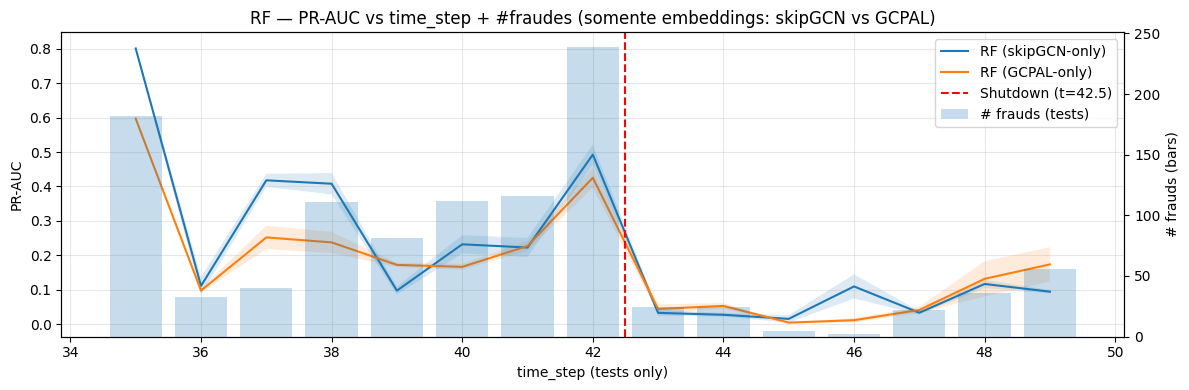

(<Figure size 1200x400 with 2 Axes>,
 <Axes: title={'center': 'RF — PR-AUC vs time_step + #fraudes (somente embeddings: skipGCN vs GCPAL)'}, xlabel='time_step (tests only)', ylabel='PR-AUC'>)

In [6]:
# Gráfico: RF com SOMENTE embeddings — skipGCN-only vs GCPAL-only
from src.utils.visualization import Visualization

# Monta o dict no formato esperado pela função (model_name -> runs)
results_summary_two = {**results_sk_only, **results_gc_only}

# Descobre os nomes exatamente como foram registrados
model_names_two = list(results_summary_two.keys())
print("Model names encontrados:", model_names_two)

Visualization.plot_pr_auc_with_fraud_bars(
    results_summary=results_summary_two,
    df_test1=df_test1,
    df_test2=df_test2,
    model_names=model_names_two,           # ex.: ["skipGCN-only", "GCPAL-only"]
    shutdown_ts=42.5,
    title="RF — PR-AUC vs time_step + #fraudes (somente embeddings: skipGCN vs GCPAL)",
)


# Treinando RF com features e embeddings

In [42]:
# ==========================================================
# RF: AF vs AF+skipGCN_EMB_PCA(5) vs AF+GCPAL_EMB_PCA(3) vs AF+ALL_EMB_PCA(5+3)
# ==========================================================
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from src.models.baseline.runner import BaselineRunner

# 1) Colunas AF e de embeddings
af_cols = [c for c in df_train.columns if c.startswith("feature_")]
sk_cols = [c for c in df_train_sk.columns if c.startswith("emb_")]              # skipGCN (emb_*)
gc_cols = [c for c in df_train_gc.columns if c.startswith("emb_gcpal_")]        # GCPAL (emb_gcpal_*)

print(f"AF: {len(af_cols)} | skipGCN emb: {len(sk_cols)} | GCPAL emb: {len(gc_cols)}")

seed_global = cfg.get("general", {}).get("seed", 42)

# --------------------------
# 2) skipGCN -> PCA(5) e MERGE por txId com splits (AF+class)
# --------------------------
sc_sk = StandardScaler(with_mean=True, with_std=True)
Ztr_sk = sc_sk.fit_transform(df_train_sk[sk_cols].to_numpy())
Zt1_sk = sc_sk.transform(df_test1_sk[sk_cols].to_numpy())
Zt2_sk = sc_sk.transform(df_test2_sk[sk_cols].to_numpy())

pca_sk = PCA(n_components=5, random_state=seed_global)
PCtr_sk = pca_sk.fit_transform(Ztr_sk)
PCt1_sk = pca_sk.transform(Zt1_sk)
PCt2_sk = pca_sk.transform(Zt2_sk)

sk_pca_cols = [f"emb_skipgcn_pca_{i}" for i in range(1, 6)]
sk_pca_train = pd.DataFrame(PCtr_sk, columns=sk_pca_cols); sk_pca_train["txId"] = df_train_sk["txId"].values
sk_pca_test1 = pd.DataFrame(PCt1_sk, columns=sk_pca_cols); sk_pca_test1["txId"] = df_test1_sk["txId"].values
sk_pca_test2 = pd.DataFrame(PCt2_sk, columns=sk_pca_cols); sk_pca_test2["txId"] = df_test2_sk["txId"].values

df_train_af_sk_pca = df_train[["txId", "time_step", "class"] + af_cols].merge(sk_pca_train, on="txId", how="inner")
df_test1_af_sk_pca = df_test1[["txId", "time_step", "class"] + af_cols].merge(sk_pca_test1, on="txId", how="inner")
df_test2_af_sk_pca = df_test2[["txId", "time_step", "class"] + af_cols].merge(sk_pca_test2, on="txId", how="inner")

af_plus_sk_pca_cols = af_cols + sk_pca_cols

# --------------------------
# 3) GCPAL -> PCA(3) e MERGE por txId com splits (AF+class)
# --------------------------
n_gcpal_pcs = 3

sc_gc = StandardScaler(with_mean=True, with_std=True)
Ztr_gc = sc_gc.fit_transform(df_train_gc[gc_cols].to_numpy())
Zt1_gc = sc_gc.transform(df_test1_gc[gc_cols].to_numpy())
Zt2_gc = sc_gc.transform(df_test2_gc[gc_cols].to_numpy())

pca_gc = PCA(n_components=n_gcpal_pcs, random_state=seed_global)
PCtr_gc = pca_gc.fit_transform(Ztr_gc)
PCt1_gc = pca_gc.transform(Zt1_gc)
PCt2_gc = pca_gc.transform(Zt2_gc)

gc_pca_cols = [f"emb_gcpal_pca_{i}" for i in range(1, n_gcpal_pcs + 1)]
gc_pca_train = pd.DataFrame(PCtr_gc, columns=gc_pca_cols); gc_pca_train["txId"] = df_train_gc["txId"].values
gc_pca_test1 = pd.DataFrame(PCt1_gc, columns=gc_pca_cols); gc_pca_test1["txId"] = df_test1_gc["txId"].values
gc_pca_test2 = pd.DataFrame(PCt2_gc, columns=gc_pca_cols); gc_pca_test2["txId"] = df_test2_gc["txId"].values

df_train_af_gc_pca = df_train[["txId", "time_step", "class"] + af_cols].merge(gc_pca_train, on="txId", how="inner")
df_test1_af_gc_pca = df_test1[["txId", "time_step", "class"] + af_cols].merge(gc_pca_test1, on="txId", how="inner")
df_test2_af_gc_pca = df_test2[["txId", "time_step", "class"] + af_cols].merge(gc_pca_test2, on="txId", how="inner")

af_plus_gc_pca_cols = af_cols + gc_pca_cols

# --------------------------
# 4) ALL_EMB_PCA = concat( skipGCN_PCA5 , GCPAL_PCA3 ) e MERGE com splits
# --------------------------
all_pca_cols = sk_pca_cols + gc_pca_cols

# Treino: junta PCs por txId
all_pca_train = sk_pca_train.merge(gc_pca_train, on="txId", how="inner")
all_pca_test1 = sk_pca_test1.merge(gc_pca_test1, on="txId", how="inner")
all_pca_test2 = sk_pca_test2.merge(gc_pca_test2, on="txId", how="inner")

df_train_af_all_pca = df_train[["txId", "time_step", "class"] + af_cols].merge(all_pca_train, on="txId", how="inner")
df_test1_af_all_pca = df_test1[["txId", "time_step", "class"] + af_cols].merge(all_pca_test1, on="txId", how="inner")
df_test2_af_all_pca = df_test2[["txId", "time_step", "class"] + af_cols].merge(all_pca_test2, on="txId", how="inner")

af_plus_all_pca_cols = af_cols + all_pca_cols  # (165 + 8)

print("Shapes (train/test1/test2):")
print(" AF:", df_train[af_cols + ['class']].shape,
      df_test1[af_cols + ['class']].shape, df_test2[af_cols + ['class']].shape)
print(" AF+skipGCN_PCA5:", df_train_af_sk_pca[af_plus_sk_pca_cols + ['class']].shape,
      df_test1_af_sk_pca[af_plus_sk_pca_cols + ['class']].shape,
      df_test2_af_sk_pca[af_plus_sk_pca_cols + ['class']].shape)
print(" AF+GCPAL_PCA3:", df_train_af_gc_pca[af_plus_gc_pca_cols + ['class']].shape,
      df_test1_af_gc_pca[af_plus_gc_pca_cols + ['class']].shape,
      df_test2_af_gc_pca[af_plus_gc_pca_cols + ['class']].shape)
print(" AF+ALL_EMB_PCA(5+3):", df_train_af_all_pca[af_plus_all_pca_cols + ['class']].shape,
      df_test1_af_all_pca[af_plus_all_pca_cols + ['class']].shape,
      df_test2_af_all_pca[af_plus_all_pca_cols + ['class']].shape)

# --------------------------
# 5) Treino (5 seeds) com BaselineRunner
# --------------------------
seeds = [seed_global + i for i in range(5)]
runner = BaselineRunner(cfg, seeds)

# RF com AF
results_rf_af = runner.run_family(
    model_key="rf",
    feature_sets={"AF": af_cols},
    df_train=df_train,
    df_test1=df_test1,
    df_test2=df_test2,
)

# RF com AF + skipGCN_EMB_PCA5
results_rf_af_sk_pca = runner.run_family(
    model_key="rf",
    feature_sets={"AF+skipGCN_EMB_PCA5": af_plus_sk_pca_cols},
    df_train=df_train_af_sk_pca,
    df_test1=df_test1_af_sk_pca,
    df_test2=df_test2_af_sk_pca,
)

# RF com AF + GCPAL_EMB_PCA3
results_rf_af_gc_pca = runner.run_family(
    model_key="rf",
    feature_sets={"AF+GCPAL_EMB_PCA3": af_plus_gc_pca_cols},
    df_train=df_train_af_gc_pca,
    df_test1=df_test1_af_gc_pca,
    df_test2=df_test2_af_gc_pca,
)

# RF com AF + ALL_EMB_PCA(5+3)
results_rf_af_all_pca = runner.run_family(
    model_key="rf",
    feature_sets={"AF+ALL_EMB_PCA(5+3)": af_plus_all_pca_cols},
    df_train=df_train_af_all_pca,
    df_test1=df_test1_af_all_pca,
    df_test2=df_test2_af_all_pca,
)

# Consolida (4 cenários)
results_summary_rf_pca = {
    **results_rf_af,
    **results_rf_af_sk_pca,
    **results_rf_af_gc_pca,
    **results_rf_af_all_pca,
}

print("✅ RF concluído para:", list(results_summary_rf_pca.keys()))
# esperado: ['AF', 'AF+skipGCN_EMB_PCA5', 'AF+GCPAL_EMB_PCA3', 'AF+ALL_EMB_PCA(5+3)']


AF: 165 | skipGCN emb: 100 | GCPAL emb: 128
Shapes (train/test1/test2):
 AF: (29894, 166) (9983, 166) (6687, 166)
 AF+skipGCN_PCA5: (29894, 171) (9983, 171) (6687, 171)
 AF+GCPAL_PCA3: (29894, 169) (9983, 169) (6687, 169)
 AF+ALL_EMB_PCA(5+3): (29894, 174) (9983, 174) (6687, 174)
✅ RF concluído para: ['RF (AF)', 'RF (AF+skipGCN_EMB_PCA5)', 'RF (AF+GCPAL_EMB_PCA3)', 'RF (AF+ALL_EMB_PCA(5+3))']


In [45]:
# ==========================================================
# Resumo (tabela) — RF: AF vs AF+skipGCN_EMB vs AF+GCPAL_EMB
# ==========================================================
import numpy as np
import pandas as pd
from IPython.display import display

# Unifica no formato esperado: { family_key: { feature_set: runs } }
results_summary = {
    "rf": results_summary_rf_pca  # deve conter as chaves: "AF", "AF+skipGCN_EMB", "AF+GCPAL_EMB"
}

def mean_std_str(values):
    arr = np.array(values, dtype=float)
    return f"{np.nanmean(arr):.3f} ± {np.nanstd(arr):.3f}"

summary_rows = []
for family_key, model_dict in results_summary.items():
    for feat_name, runs in model_dict.items():
        for label, key in [
            ("Pré (35–42)", "Global (35–42)"),
            ("Pós (43–49)", "Global (43–49)"),
            ("Global (35–49)", "Global (35–49)"),
        ]:
            summary_rows.append({
                "Família": family_key.upper(),
                "Features": feat_name,
                "Período": label,
                "Gini":          mean_std_str([r[key]["Gini"] for r in runs]),
                "PR-AUC":        mean_std_str([r[key]["PR-AUC"] for r in runs]),
                "PR-AUC/Prev":   mean_std_str([r[key]["PR-AUC/Prev"] for r in runs]),
                "F1":            mean_std_str([r[key]["F1"] for r in runs]),
                "Recall":        mean_std_str([r[key]["Recall"] for r in runs]),
                "Precision":     mean_std_str([r[key]["Precision"] for r in runs]),
            })

df_summary_rf = (
    pd.DataFrame(summary_rows)
      .set_index(["Família","Features","Período"])
      .sort_index()
)

display(df_summary_rf)


Gini         PR-AUC  \
Família Features                 Período                                        
RF      RF (AF)                  Global (35–49)  0.828 ± 0.006  0.779 ± 0.002   
                                 Pré (35–42)     0.935 ± 0.005  0.906 ± 0.003   
                                 Pós (43–49)     0.204 ± 0.015  0.044 ± 0.002   
        RF (AF+ALL_EMB_PCA(5+3)) Global (35–49)  0.820 ± 0.016  0.779 ± 0.004   
                                 Pré (35–42)     0.923 ± 0.006  0.903 ± 0.003   
                                 Pós (43–49)     0.234 ± 0.086  0.046 ± 0.006   
        RF (AF+GCPAL_EMB_PCA3)   Global (35–49)  0.825 ± 0.012  0.780 ± 0.005   
                                 Pré (35–42)     0.930 ± 0.003  0.906 ± 0.003   
                                 Pós (43–49)     0.219 ± 0.070  0.042 ± 0.003   
        RF (AF+skipGCN_EMB_PCA5) Global (35–49)  0.811 ± 0.023  0.779 ± 0.006   
                                 Pré (35–42)     0.927 ± 0.006  0.905 ± 0.003   
                                 Pós (43–49)     0.150 ± 0.127  0.044 ± 0.005   

                                                    PR-AUC/Prev  \
Família Features                 Período                          
RF      RF (AF)                  Global (35–49)  11.994 ± 0.034   
                                 Pré (35–42)      9.892 ± 0.030   
                                 Pós (43–49)      1.727 ± 0.062   
        RF (AF+ALL_EMB_PCA(5+3)) Global (35–49)  11.989 ± 0.065   
                                 Pré (35–42)      9.858 ± 0.032   
                                 Pós (43–49)      1.803 ± 0.230   
        RF (AF+GCPAL_EMB_PCA3)   Global (35–49)  12.014 ± 0.069   
                                 Pré (35–42)      9.900 ± 0.033   
                                 Pós (43–49)      1.666 ± 0.116   
        RF (AF+skipGCN_EMB_PCA5) Global (35–49)  11.987 ± 0.086   
                                 Pré (35–42)      9.883 ± 0.030   
                                 Pós (43–49)      1.734 ± 0.209   

                                                            F1         Recall  \
Família Features                 Período                                        
RF      RF (AF)                  Global (35–49)  0.790 ± 0.015  0.673 ± 0.022   
                                 Pré (35–42)     0.871 ± 0.016  0.794 ± 0.027   
                                 Pós (43–49)     0.033 ± 0.000  0.018 ± 0.000   
        RF (AF+ALL_EMB_PCA(5+3)) Global (35–49)  0.793 ± 0.007  0.675 ± 0.013   
                                 Pré (35–42)     0.874 ± 0.007  0.796 ± 0.015   
                                 Pós (43–49)     0.034 ± 0.000  0.018 ± 0.000   
        RF (AF+GCPAL_EMB_PCA3)   Global (35–49)  0.801 ± 0.006  0.683 ± 0.008   
                                 Pré (35–42)     0.883 ± 0.007  0.807 ± 0.010   
                                 Pós (43–49)     0.031 ± 0.004  0.017 ± 0.002   
        RF (AF+skipGCN_EMB_PCA5) Global (35–49)  0.803 ± 0.009  0.686 ± 0.010   
                                 Pré (35–42)     0.886 ± 0.009  0.809 ± 0.012   
                                 Pós (43–49)     0.034 ± 0.000  0.018 ± 0.000   

                                                     Precision  
Família Features                 Período                        
RF      RF (AF)                  Global (35–49)  0.957 ± 0.018  
                                 Pré (35–42)     0.967 ± 0.017  
                                 Pós (43–49)     0.298 ± 0.053  
        RF (AF+ALL_EMB_PCA(5+3)) Global (35–49)  0.961 ± 0.012  
                                 Pré (35–42)     0.968 ± 0.013  
                                 Pós (43–49)     0.366 ± 0.058  
        RF (AF+GCPAL_EMB_PCA3)   Global (35–49)  0.966 ± 0.009  
                                 Pré (35–42)     0.977 ± 0.008  
                                 Pós (43–49)     0.257 ± 0.043  
        RF (AF+skipGCN_EMB_PCA5) Global (35–49)  0.969 ± 0.007  
                                 Pré (35–42)     0.978 ± 0.006  
    

Model names encontrados: ['RF (AF)', 'RF (AF+skipGCN_EMB)', 'RF (AF+GCPAL_EMB)']


/Users/leonardoribeiro/Documents/DataScience/MBA_USP/TCC/src/utils/visualization.py:114: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y_mean = agg["pr_auc_mean"].interpolate().fillna(method="bfill").fillna(method="ffill")


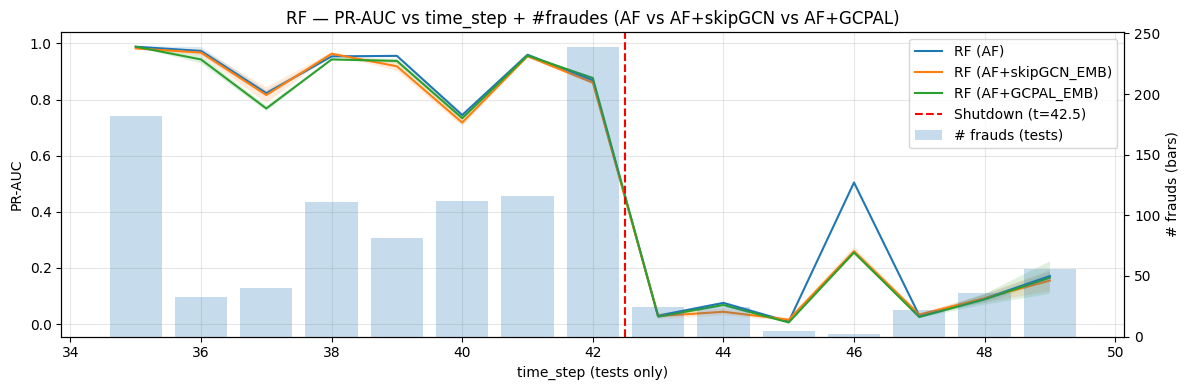

(<Figure size 1200x400 with 2 Axes>,
 <Axes: title={'center': 'RF — PR-AUC vs time_step + #fraudes (AF vs AF+skipGCN vs AF+GCPAL)'}, xlabel='time_step (tests only)', ylabel='PR-AUC'>)

In [27]:
# Gráfico: RF — AF vs AF+skipGCN_EMB vs AF+GCPAL_EMB
from src.utils.visualization import Visualization

# Seleciona explicitamente na ordem desejada
results_summary_three = {
    k: results_summary_rf[k]
    for k in ['RF (AF)', 'RF (AF+skipGCN_EMB)', 'RF (AF+GCPAL_EMB)']
    if k in results_summary_rf
}

model_names_three = list(results_summary_three.keys())
print("Model names encontrados:", model_names_three)

Visualization.plot_pr_auc_with_fraud_bars(
    results_summary=results_summary_three,
    df_test1=df_test1,
    df_test2=df_test2,
    model_names=model_names_three,
    shutdown_ts=42.5,
    title="RF — PR-AUC vs time_step + #fraudes (AF vs AF+skipGCN vs AF+GCPAL)",
)


# Treinando RF com features embeddings (com PCA)

In [ ]:
# ==========================================================
# RF: AF vs AF+skipGCN_EMB_PCA(5) vs AF+GCPAL_EMB_PCA(3) — FIX names
# ==========================================================
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from src.models.baseline.runner import BaselineRunner

# 1) Colunas AF e de embeddings
af_cols = [c for c in df_train.columns if c.startswith("feature_")]
sk_cols = [c for c in df_train_sk.columns if c.startswith("emb_")]              # skipGCN (emb_*)
gc_cols = [c for c in df_train_gc.columns if c.startswith("emb_gcpal_")]        # GCPAL (emb_gcpal_*)

print(f"AF: {len(af_cols)} | skipGCN emb: {len(sk_cols)} | GCPAL emb: {len(gc_cols)}")

seed_global = cfg.get("general", {}).get("seed", 42)

# --------------------------
# 2) skipGCN -> PCA(5) e MERGE por txId com splits (AF+class)
# --------------------------
sc_sk = StandardScaler(with_mean=True, with_std=True)
Ztr_sk = sc_sk.fit_transform(df_train_sk[sk_cols].to_numpy())
Zt1_sk = sc_sk.transform(df_test1_sk[sk_cols].to_numpy())
Zt2_sk = sc_sk.transform(df_test2_sk[sk_cols].to_numpy())

pca_sk = PCA(n_components=5, random_state=seed_global)
PCtr_sk = pca_sk.fit_transform(Ztr_sk)
PCt1_sk = pca_sk.transform(Zt1_sk)
PCt2_sk = pca_sk.transform(Zt2_sk)

sk_pca_cols = [f"emb_skipgcn_pca_{i}" for i in range(1, 6)]
sk_pca_train = pd.DataFrame(PCtr_sk, columns=sk_pca_cols); sk_pca_train["txId"] = df_train_sk["txId"].values
sk_pca_test1 = pd.DataFrame(PCt1_sk, columns=sk_pca_cols); sk_pca_test1["txId"] = df_test1_sk["txId"].values
sk_pca_test2 = pd.DataFrame(PCt2_sk, columns=sk_pca_cols); sk_pca_test2["txId"] = df_test2_sk["txId"].values

df_train_af_sk_pca = df_train[["txId", "time_step", "class"] + af_cols].merge(sk_pca_train, on="txId", how="inner")
df_test1_af_sk_pca = df_test1[["txId", "time_step", "class"] + af_cols].merge(sk_pca_test1, on="txId", how="inner")
df_test2_af_sk_pca = df_test2[["txId", "time_step", "class"] + af_cols].merge(sk_pca_test2, on="txId", how="inner")

af_plus_sk_pca_cols = af_cols + sk_pca_cols

# --------------------------
# 3) GCPAL -> PCA(3) e MERGE por txId com splits (AF+class)
# --------------------------
n_gcpal_pcs = 3

sc_gc = StandardScaler(with_mean=True, with_std=True)
Ztr_gc = sc_gc.fit_transform(df_train_gc[gc_cols].to_numpy())
Zt1_gc = sc_gc.transform(df_test1_gc[gc_cols].to_numpy())
Zt2_gc = sc_gc.transform(df_test2_gc[gc_cols].to_numpy())

pca_gc = PCA(n_components=n_gcpal_pcs, random_state=seed_global)
PCtr_gc = pca_gc.fit_transform(Ztr_gc)
PCt1_gc = pca_gc.transform(Zt1_gc)
PCt2_gc = pca_gc.transform(Zt2_gc)

gc_pca_cols = [f"emb_gcpal_pca_{i}" for i in range(1, n_gcpal_pcs + 1)]
gc_pca_train = pd.DataFrame(PCtr_gc, columns=gc_pca_cols); gc_pca_train["txId"] = df_train_gc["txId"].values
gc_pca_test1 = pd.DataFrame(PCt1_gc, columns=gc_pca_cols); gc_pca_test1["txId"] = df_test1_gc["txId"].values
gc_pca_test2 = pd.DataFrame(PCt2_gc, columns=gc_pca_cols); gc_pca_test2["txId"] = df_test2_gc["txId"].values

df_train_af_gc_pca = df_train[["txId", "time_step", "class"] + af_cols].merge(gc_pca_train, on="txId", how="inner")
df_test1_af_gc_pca = df_test1[["txId", "time_step", "class"] + af_cols].merge(gc_pca_test1, on="txId", how="inner")
df_test2_af_gc_pca = df_test2[["txId", "time_step", "class"] + af_cols].merge(gc_pca_test2, on="txId", how="inner")

af_plus_gc_pca_cols = af_cols + gc_pca_cols

print("Shapes (train/test1/test2):")
print(" AF:", df_train[af_cols + ['class']].shape,
      df_test1[af_cols + ['class']].shape, df_test2[af_cols + ['class']].shape)
print(" AF+skipGCN_PCA5:", df_train_af_sk_pca[af_plus_sk_pca_cols + ['class']].shape,
      df_test1_af_sk_pca[af_plus_sk_pca_cols + ['class']].shape,
      df_test2_af_sk_pca[af_plus_sk_pca_cols + ['class']].shape)
print(" AF+GCPAL_PCA3:", df_train_af_gc_pca[af_plus_gc_pca_cols + ['class']].shape,
      df_test1_af_gc_pca[af_plus_gc_pca_cols + ['class']].shape,
      df_test2_af_gc_pca[af_plus_gc_pca_cols + ['class']].shape)

# --------------------------
# 4) Treino (5 seeds) com BaselineRunner
# --------------------------
seeds = [seed_global + i for i in range(5)]
runner = BaselineRunner(cfg, seeds)

# RF com AF
results_rf_af = runner.run_family(
    model_key="rf",
    feature_sets={"AF": af_cols},  # <<<< chaves simples
    df_train=df_train,
    df_test1=df_test1,
    df_test2=df_test2,
)

# RF com AF + skipGCN_EMB_PCA5
results_rf_af_sk_pca = runner.run_family(
    model_key="rf",
    feature_sets={"AF+skipGCN_EMB_PCA5": af_plus_sk_pca_cols},  # <<<< chaves simples
    df_train=df_train_af_sk_pca,
    df_test1=df_test1_af_sk_pca,
    df_test2=df_test2_af_sk_pca,
)

# RF com AF + GCPAL_EMB_PCA3
results_rf_af_gc_pca = runner.run_family(
    model_key="rf",
    feature_sets={"AF+GCPAL_EMB_PCA3": af_plus_gc_pca_cols},  # <<<< chaves simples
    df_train=df_train_af_gc_pca,
    df_test1=df_test1_af_gc_pca,
    df_test2=df_test2_af_gc_pca,
)

# Consolida
results_summary_rf_pca = {
    **results_rf_af,
    **results_rf_af_sk_pca,
    **results_rf_af_gc_pca,
}

print("✅ RF concluído para:", list(results_summary_rf_pca.keys()))
# esperado: ['RF (AF)', 'RF (AF+skipGCN_EMB_PCA5)', 'RF (AF+GCPAL_EMB_PCA3)']


AF: 165 | skipGCN emb: 100 | GCPAL emb: 128
Shapes (train/test1/test2):
 AF: (29894, 166) (9983, 166) (6687, 166)
 AF+skipGCN_PCA5: (29894, 171) (9983, 171) (6687, 171)
 AF+GCPAL_PCA3: (29894, 169) (9983, 169) (6687, 169)
✅ RF concluído para: ['RF (AF)', 'RF (AF+skipGCN_EMB_PCA5)', 'RF (AF+GCPAL_EMB_PCA3)']


In [38]:
# ==========================================================
# Resumo (tabela) — RF: AF vs AF+skipGCN_EMB_PCA5 vs AF+GCPAL_EMB_PCA3
# ==========================================================
import numpy as np
import pandas as pd
from IPython.display import display

# results_summary_rf_pca deve conter as chaves:
# "RF (AF)", "RF (AF+skipGCN_EMB_PCA5)", "RF (AF+GCPAL_EMB_PCA3)"
print("Chaves encontradas:", list(results_summary_rf_pca.keys()))

results_summary = {
    "rf": results_summary_rf_pca
}

def mean_std_str(values):
    arr = np.array(values, dtype=float)
    return f"{np.nanmean(arr):.3f} ± {np.nanstd(arr):.3f}"

summary_rows = []
for family_key, model_dict in results_summary.items():
    for feat_name, runs in model_dict.items():
        for label, key in [
            ("Pré (35–42)", "Global (35–42)"),
            ("Pós (43–49)", "Global (43–49)"),
            ("Global (35–49)", "Global (35–49)"),
        ]:
            summary_rows.append({
                "Família": family_key.upper(),
                "Features": feat_name,
                "Período": label,
                "Gini":          mean_std_str([r[key]["Gini"] for r in runs]),
                "PR-AUC":        mean_std_str([r[key]["PR-AUC"] for r in runs]),
                "PR-AUC/Prev":   mean_std_str([r[key]["PR-AUC/Prev"] for r in runs]),
                "F1":            mean_std_str([r[key]["F1"] for r in runs]),
                "Recall":        mean_std_str([r[key]["Recall"] for r in runs]),
                "Precision":     mean_std_str([r[key]["Precision"] for r in runs]),
            })

df_summary_rf_pca = (
    pd.DataFrame(summary_rows)
      .set_index(["Família","Features","Período"])
      .sort_index()
)

# Opcional: reordenar linhas por Features em uma ordem específica
order = ["RF (AF)", "RF (AF+skipGCN_EMB_PCA5)", "RF (AF+GCPAL_EMB_PCA3)"]
df_summary_rf_pca = df_summary_rf_pca.reindex(
    pd.MultiIndex.from_product(
        [["RF"], order, ["Pré (35–42)", "Pós (43–49)", "Global (35–49)"]],
        names=["Família","Features","Período"]
    )
)

display(df_summary_rf_pca)


Chaves encontradas: ['RF (AF)', 'RF (AF+skipGCN_EMB_PCA5)', 'RF (AF+GCPAL_EMB_PCA3)']


Gini         PR-AUC  \
Família Features                 Período                                        
RF      RF (AF)                  Pré (35–42)     0.935 ± 0.005  0.906 ± 0.003   
                                 Pós (43–49)     0.204 ± 0.015  0.044 ± 0.002   
                                 Global (35–49)  0.828 ± 0.006  0.779 ± 0.002   
        RF (AF+skipGCN_EMB_PCA5) Pré (35–42)     0.927 ± 0.006  0.905 ± 0.003   
                                 Pós (43–49)     0.150 ± 0.127  0.044 ± 0.005   
                                 Global (35–49)  0.811 ± 0.023  0.779 ± 0.006   
        RF (AF+GCPAL_EMB_PCA3)   Pré (35–42)     0.930 ± 0.003  0.906 ± 0.003   
                                 Pós (43–49)     0.219 ± 0.070  0.042 ± 0.003   
                                 Global (35–49)  0.825 ± 0.012  0.780 ± 0.005   

                                                    PR-AUC/Prev  \
Família Features                 Período                          
RF      RF (AF)                  Pré (35–42)      9.892 ± 0.030   
                                 Pós (43–49)      1.727 ± 0.062   
                                 Global (35–49)  11.994 ± 0.034   
        RF (AF+skipGCN_EMB_PCA5) Pré (35–42)      9.883 ± 0.030   
                                 Pós (43–49)      1.734 ± 0.209   
                                 Global (35–49)  11.987 ± 0.086   
        RF (AF+GCPAL_EMB_PCA3)   Pré (35–42)      9.900 ± 0.033   
                                 Pós (43–49)      1.666 ± 0.116   
                                 Global (35–49)  12.014 ± 0.069   

                                                            F1         Recall  \
Família Features                 Período                                        
RF      RF (AF)                  Pré (35–42)     0.871 ± 0.016  0.794 ± 0.027   
                                 Pós (43–49)     0.033 ± 0.000  0.018 ± 0.000   
                                 Global (35–49)  0.790 ± 0.015  0.673 ± 0.022   
        RF (AF+skipGCN_EMB_PCA5) Pré (35–42)     0.886 ± 0.009  0.809 ± 0.012   
                                 Pós (43–49)     0.034 ± 0.000  0.018 ± 0.000   
                                 Global (35–49)  0.803 ± 0.009  0.686 ± 0.010   
        RF (AF+GCPAL_EMB_PCA3)   Pré (35–42)     0.883 ± 0.007  0.807 ± 0.010   
                                 Pós (43–49)     0.031 ± 0.004  0.017 ± 0.002   
                                 Global (35–49)  0.801 ± 0.006  0.683 ± 0.008   

                                                     Precision  
Família Features                 Período                        
RF      RF (AF)                  Pré (35–42)     0.967 ± 0.017  
                                 Pós (43–49)     0.298 ± 0.053  
                                 Global (35–49)  0.957 ± 0.018  
        RF (AF+skipGCN_EMB_PCA5) Pré (35–42)     0.978 ± 0.006  
                                 Pós (43–49)     0.315 ± 0.052  
                                 Global (35–49)  0.969 ± 0.007  
        RF (AF+GCPAL_EMB_PCA3)   Pré (35–42)     0.977 ± 0.008  
                                 Pós (43–49)     0.257 ± 0.043  
                                 Global (35–49)  0.966 ± 0.009

Model names encontrados: ['RF (AF)', 'RF (AF+skipGCN_EMB_PCA5)', 'RF (AF+GCPAL_EMB_PCA3)']


/Users/leonardoribeiro/Documents/DataScience/MBA_USP/TCC/src/utils/visualization.py:114: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y_mean = agg["pr_auc_mean"].interpolate().fillna(method="bfill").fillna(method="ffill")


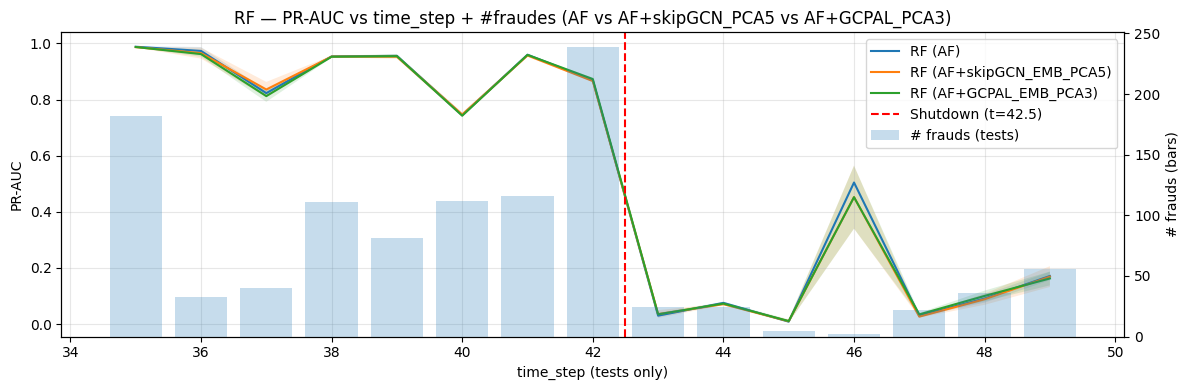

(<Figure size 1200x400 with 2 Axes>,
 <Axes: title={'center': 'RF — PR-AUC vs time_step + #fraudes (AF vs AF+skipGCN_PCA5 vs AF+GCPAL_PCA3)'}, xlabel='time_step (tests only)', ylabel='PR-AUC'>)

In [40]:
# Gráfico: RF — AF vs AF+skipGCN_EMB_PCA5 vs AF+GCPAL_EMB_PCA3
from src.utils.visualization import Visualization

# Seleciona na ordem desejada, a partir do dicionário com PCA
results_summary_three = {
    k: results_summary_rf_pca[k]
    for k in ['RF (AF)', 'RF (AF+skipGCN_EMB_PCA5)', 'RF (AF+GCPAL_EMB_PCA3)']
    if k in results_summary_rf_pca
}

model_names_three = list(results_summary_three.keys())
print("Model names encontrados:", model_names_three)

Visualization.plot_pr_auc_with_fraud_bars(
    results_summary=results_summary_three,
    df_test1=df_test1,
    df_test2=df_test2,
    model_names=model_names_three,
    shutdown_ts=42.5,
    title="RF — PR-AUC vs time_step + #fraudes (AF vs AF+skipGCN_PCA5 vs AF+GCPAL_PCA3)",
)


/var/folders/0j/y0hjl4v54fld89f_fkf4j7x40000gn/T/ipykernel_36855/210445343.py:60: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y_lo = (agg["f1_mean"] - std).fillna(method="ffill").fillna(method="bfill")
/var/folders/0j/y0hjl4v54fld89f_fkf4j7x40000gn/T/ipykernel_36855/210445343.py:61: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y_hi = (agg["f1_mean"] + std).fillna(method="ffill").fillna(method="bfill")


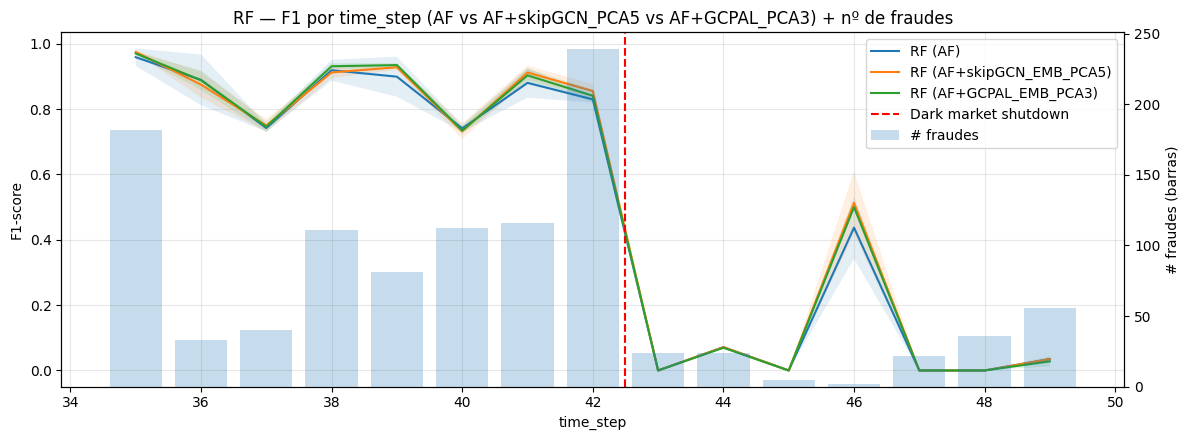

In [41]:
# === F1-score (3 curvas) + barras com nº de fraudes por time_step ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Dicionário com os três modelos (já treinados na parte PCA)
results_summary_three = {
    k: results_summary_rf_pca[k]
    for k in ['RF (AF)', 'RF (AF+skipGCN_EMB_PCA5)', 'RF (AF+GCPAL_EMB_PCA3)']
    if k in results_summary_rf_pca
}
model_names = list(results_summary_three.keys())

# 1) Agrega F1 por time_step para cada modelo
agg_by_model = {}
for model_name in model_names:
    runs = results_summary_three[model_name]
    dfs = []
    for r in runs:
        df = pd.DataFrame(r["por_time_step"])  # contém: time_step, f1, etc.
        df["seed"] = r["seed"]
        dfs.append(df)
    df_all = pd.concat(dfs, ignore_index=True)
    agg = (
        df_all.groupby("time_step", as_index=False)
              .agg(f1_mean=("f1", "mean"),
                   f1_std =("f1", "std"))
              .sort_values("time_step")
    )
    agg_by_model[model_name] = agg

# 2) Conta fraudes (class==1) apenas nos conjuntos de teste
df_all_test = pd.concat([df_test1, df_test2], ignore_index=True)
frauds = (
    df_all_test[df_all_test["class"] == 1]
      .groupby("time_step", as_index=False)
      .size()
      .rename(columns={"size": "fraud_count"})
      .sort_values("time_step")
)

# Eixo X = somente timesteps dos testes (para alinhar com a avaliação)
time_axis = np.array(sorted(df_all_test["time_step"].unique()), dtype=int)

# Reindexa fraudes e curvas no mesmo eixo
frauds_full = pd.DataFrame({"time_step": time_axis}).merge(frauds, on="time_step", how="left")
frauds_full["fraud_count"] = frauds_full["fraud_count"].fillna(0).astype(int)
for k, agg in agg_by_model.items():
    agg_by_model[k] = pd.DataFrame({"time_step": time_axis}).merge(agg, on="time_step", how="left")

# 3) Plot: F1 (eixo esquerdo) + barras de fraudes (eixo direito)
fig, ax = plt.subplots(figsize=(12, 4.5))
ax2 = ax.twinx()

# Curvas de F1
for model_name, agg in agg_by_model.items():
    ax.plot(agg["time_step"], agg["f1_mean"], label=model_name)
    std = agg["f1_std"].fillna(0).to_numpy()
    # bandas de desvio
    y_lo = (agg["f1_mean"] - std).fillna(method="ffill").fillna(method="bfill")
    y_hi = (agg["f1_mean"] + std).fillna(method="ffill").fillna(method="bfill")
    ax.fill_between(agg["time_step"], y_lo, y_hi, alpha=0.12)

# Barras com nº de fraudes (eixo direito)
bar = ax2.bar(frauds_full["time_step"], frauds_full["fraud_count"],
              alpha=0.25, width=0.8, label="# fraudes")

# Linha do shutdown em 42.5
shutdown_ts = 42.5
ax.axvline(shutdown_ts, linestyle="--", linewidth=1.5, color="red", label="Dark market shutdown")

# Rótulos e grade
ax.set_xlabel("time_step")
ax.set_ylabel("F1-score")
ax2.set_ylabel("# fraudes (barras)")
ax.set_title("RF — F1 por time_step (AF vs AF+skipGCN_PCA5 vs AF+GCPAL_PCA3) + nº de fraudes")

ax.grid(True, axis="both", alpha=0.3)

# Legenda combinada
handles1, labels1 = ax.get_legend_handles_labels()
handles = handles1 + [bar]
labels = labels1 + ["# fraudes"]
ax.legend(handles, labels, loc="best")

plt.tight_layout()
plt.show()
